In [1]:
import gurobipy as gp
from gurobipy import GRB
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import pickle
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
with open("data/travel_time.pkl", "rb") as file:
    travel_time = pickle.load(file)
D = np.zeros((26,26,26))
c_matrix= travel_time.copy()
for i in range(26):
    for j in range(26):
        for k in range(26):
            D[i,j,k] = min(c_matrix[i][k]+c_matrix[k][i],c_matrix[j][k]+c_matrix[k][j],c_matrix[j][k]+c_matrix[k][i]-c_matrix[j][i],c_matrix[i][k]+c_matrix[k][j]-c_matrix[i][j])
            if D[i,j,k]<0:
                D[i,j,k]=0

In [3]:
#dfbase = pd.read_pickle('base.pkl')
#dfbaset = pd.read_pickle('base_4time.pkl')#update
#dfbasetherd = pd.read_pickle('vars_basecase_time_herd.pkl')
#dfod = pd.read_pickle('base_od.pkl')
#dfodt = pd.read_pickle('base_od_4time.pkl')#update
#dfherd = pd.read_pickle('base_4time_empweighted_500lambda.pkl')
#dfrand = pd.read_pickle('vars_basecase_od_time_herd_case60100.pkl')
dfrand = pd.read_pickle('results/base_od_4time_emp_1lambda_smooth.pkl')
#16876659.42004843

districts = {0: 'Antelope Valley', 
             1: 'East Valley', 
             2: 'Glendale', 
             3: 'San Fernando', 
             4: 'West Valley',
             5: 'Alhambra', 
             6: 'El Monte', 
             7: 'Foothill', 
             8: 'Pasadena', 
             9: 'Pomona',
             10: 'Central', 
             11: 'Hollywood-Wilshire', 
             12: 'Northeast', 
             13: 'West',
             14: 'Compton', 
             15: 'South', 
             16: 'Southeast', 
             17: 'Southwest',
             18: 'Bellflower', 
             19: 'East Los Angeles', 
             20: 'San Antonio', 
             21: 'Whittier',
             22: 'Harbor', 
             23: 'Inglewood', 
             24: 'Long Beach', 
             25: 'Torrance'}


In [4]:
#dfxbase = dfbase[dfbase.name=='x']
#dfybase = dfbase[dfbase.name=='y']
#dfzbase = dfbase[dfbase.name=='z']
#dfxbaset = dfbaset[dfbaset.name=='x']
#dfybaset = dfbaset[dfbaset.name=='y']
#dfzbaset = dfbaset[dfbaset.name=='z']
#dfxbasetherd = dfbasetherd[dfbasetherd.name=='x']
#dfybasetherd = dfbasetherd[dfbasetherd.name=='y']
#dfzbasetherd = dfbasetherd[dfbasetherd.name=='z']
#dfxod = dfod[dfod.name=='x']
#dfyod = dfod[dfod.name=='y']
#dfzod = dfod[dfod.name=='z']
#dfxodt = dfodt[dfodt.name=='x']
#dfyodt = dfodt[dfodt.name=='y']
#dfzodt = dfodt[dfodt.name=='z']
#dfxherd = dfherd[dfherd.name=='x']
#dfyherd = dfherd[dfherd.name=='y']
#dfzherd = dfherd[dfherd.name=='z']
dfxrand = dfrand[dfrand.name=='x']
dfyrand = dfrand[dfrand.name=='y']
dfzrand = dfrand[dfrand.name=='z']

In [5]:
total_pop = [420697,443569,344450,526877,899111,339399,419797,308499,140361,547523,354750,479505,287613,666399,278815,193899,166374,379199,356465,195082,407864,321720,201739,411617,469439,465691]


In [6]:
#print('lambda = 500')
#print(Herd500_herd)
#print('lambda = 10000')
#print(Herd10000_herd)
#print('diff')
#print(Herd10000_herd-Herd500_herd)
emp=[0.9785489423063246,
0.9749523393023726,
0.9810134958440276,
0.9715990029226316,
0.9512510687291531,
0.9793683522808072,
0.9739319327227332,
0.9817156078851325,
0.9915252477779021,
0.9678482424468472,
0.9760508448195166,
0.9657752125951641,
0.9784091897580796,
0.967984322913777,
0.9795198849727248,
0.9859672856449567,
0.9874863827092342,
0.9723956829474802,
0.9745472149882571,
0.985468457303294,
0.9697058020586842,
0.9771345654416476,
0.9898114604005365,
0.979337971566636,
0.9766137484373549,
0.9772144560727959]

In [7]:
HL = np.array(emp)*np.array(total_pop)

In [8]:
score = 0
groupedz = dfzrand.groupby(['i', 'j','k'])
resultsz = groupedz.sum()
groupedy = dfyrand.groupby(['i', 'j'])
resultsy = groupedy.sum()
for i in range(26):
    for j in range(26):
        score += resultsy['value'][(i,j)]*(2*travel_time[i][j])
        for k in range(26):     
            score += resultsz['value'][(i,j,k)]*D[i][j][k]
print(score)
ics = score.copy()

/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_68151/3978022530.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultsz = groupedz.sum()
/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_68151/3978022530.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultsy = groupedy.sum()


196572213.4149999


# Base model + OD + 6 periods + 60% herd imunity

In [9]:
'''
flow_matrix = np.zeros((26,26,6))
flow_matrix_od = np.zeros((26,26,26,6))
for t in range(6):
    for i in range(26):
        for j in range(26):
            new = dfyrand[dfyrand['i']==i]
            new = new[new['j']==j]
            new = new[new['t']==t]
            flow_matrix[i,j,t] = sum(new.value)
            for k in range(26):
                new2 = dfzrand[dfzrand['i']==i]
                new2 = new2[new2['j']==j]
                new2 = new2[new2['k']==k]
                new2 = new2[new2['t']==t]
                flow_matrix_od[i,j,k,t] = sum(new2.value)
'''
flow_matrix = np.zeros((26,26,6))
flow_matrix_od = np.zeros((26,26,26,6))
groupedz = dfzrand.groupby(['t','i', 'j','k'])
resultsz = groupedz.sum()
groupedy = dfyrand.groupby(['t','i', 'j'])
resultsy = groupedy.sum()
for t in range(6):
    for i in range(26):
        for j in range(26):
            flow_matrix[i,j,t] = resultsy['value'][(t,i,j)]
            for k in range(26):     
                flow_matrix_od[i,j,k,t] = resultsz['value'][(t,i,j,k)]
sites = list(dfxrand[dfxrand.value==1].i)

indices = np.arange(len(districts))
index_names = [districts[i] for i in indices]
categories = []
values = np.zeros((5,6))
sites_map = {}
count = 0
for site in sites:
    print(districts[site])
    sites_map[site]=count
    count+=1
    categories.append(districts[site])
    #print(np.sum(flow_matrix[:,site,:])+np.sum(flow_matrix_od[:,:,site,:]))
    #values.append(np.sum(flow_matrix[:,site,:])+np.sum(flow_matrix_od[:,:,site,:]))
print('more smooth')

/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_68151/2361208099.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultsz = groupedz.sum()
/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_68151/2361208099.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultsy = groupedy.sum()


San Fernando
West Valley
El Monte
Central
South
Torrance
more smooth


In [10]:
flow_matrix1 = np.zeros((26,26,6))
flow_matrix_od1 = np.zeros((26,26,26,6))
groupedz = dfzrand.groupby(['t','i', 'j','k'])
resultsz = groupedz.sum()
groupedy = dfyrand.groupby(['t','i', 'j'])
resultsy = groupedy.sum()
for t in range(6):
    for i in range(26):
        for j in range(26):
            flow_matrix1[i,j,t] = resultsy['value'][(t,i,j)]
            for k in range(26):     
                flow_matrix_od1[i,j,k,t] = resultsz['value'][(t,i,j,k)]



/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_68151/385149470.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultsz = groupedz.sum()
/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_68151/385149470.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultsy = groupedy.sum()


In [11]:
np.sum(flow_matrix_od1-flow_matrix_od)

0.0

In [12]:
#print(np.where(flow_matrix[0]>0)[0][0])
first = 0
second = 0
third = 0
fourth = 0
fifth = 0
for site in list(districts.keys()):
    candiates = travel_time[site,:].copy()
    for vac_site in sites:
        candiates[vac_site] -= 1000
    sorted_indices = np.argsort(candiates)
    index1 = sorted_indices[0]
    index2 = sorted_indices[1]
    index3 = sorted_indices[2]
    index4 = sorted_indices[4]
    index5 = sorted_indices[5]
    percentage = 100*np.sum(flow_matrix[site,index1,:])/np.sum(flow_matrix[site])
    values[0,sites_map[index1]] += np.sum(flow_matrix[site,index1,:])
    values[1,sites_map[index2]] += np.sum(flow_matrix[site,index2,:])
    values[2,sites_map[index3]] += np.sum(flow_matrix[site,index3,:])
    values[3,sites_map[index4]] += np.sum(flow_matrix[site,index4,:])
    values[4,sites_map[index5]] += np.sum(flow_matrix[site,index5,:])
    percentage2 = 100*np.sum(flow_matrix[site,index2,:])/np.sum(flow_matrix[site])
    percentage3 = 100*np.sum(flow_matrix[site,index3,:])/np.sum(flow_matrix[site])
    first += np.sum(flow_matrix[site,index1,:])
    second += np.sum(flow_matrix[site,index2,:])
    third += np.sum(flow_matrix[site,index3,:])
    fourth += np.sum(flow_matrix[site,index4,:])
    fifth += np.sum(flow_matrix[site,index5,:])
    if percentage>100:
        print(districts[site])
        print(site)
        #print('preferred',districts[np.argmin(travel_time[site,:])])
        #print('actual',districts[np.where(flow_matrix[site]>0)[0][0]])
        print(percentage,'% go to closest vaccination site')
        print(percentage2,'% go to second closest vaccination site')
        print(percentage3,'% go to third closest vaccination site')


In [13]:
with open("data/travel_time.pkl", "rb") as file:
    c_m_v = pickle.load(file)

In [14]:
first_od = 0
second_od = 0
third_od = 0
fourth_od = 0
fifth_od = 0
first_odo = 0
second_odo = 0
third_odo = 0
fourth_odo = 0
fifth_odo = 0
first_odd = 0
second_odd = 0
third_odd = 0
fourth_odd = 0
fifth_odd = 0
for site in list(districts.keys()):
    for site2 in list(districts.keys()):
        candiates2 = D[site,site2,:].copy()
        candiates2[site] = -1
        for vac_site in sites:
            candiates2[vac_site] -= 1000
        sorted_indices = np.argsort(candiates2)
        index1 = sorted_indices[0]
        index2 = sorted_indices[1]
        index3 = sorted_indices[2]
        index4 = sorted_indices[3]
        index5 = sorted_indices[4]
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route = 100*(np.sum(flow_matrix_od[site,site2,index1]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route = 100
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route2 = 100*(np.sum(flow_matrix_od[site,site2,index2]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route2 = 100
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route3 = 100*(np.sum(flow_matrix_od[site,site2,index3]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route3 = 100  
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route4 = 100*(np.sum(flow_matrix_od[site,site2,index4]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route4 = 100 
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route5 = 100*(np.sum(flow_matrix_od[site,site2,index5]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route5 = 100 
        first_od += np.sum(flow_matrix_od[site,site2,index1])
        if c_m_v[site,index1]<c_m_v[site2,index1]:
            first_odo += np.sum(flow_matrix_od[site,site2,index1])
        else:
            first_odd += np.sum(flow_matrix_od[site,site2,index1])
        if index2 == site2:
            values[0,sites_map[index1]] += np.sum(flow_matrix_od[site,site2,index1])
            values[0,sites_map[index2]] += np.sum(flow_matrix_od[site,site2,index2])
            values[1,sites_map[index3]] += np.sum(flow_matrix_od[site,site2,index3])
            values[2,sites_map[index4]] += np.sum(flow_matrix_od[site,site2,index4])
            values[3,sites_map[index5]] += np.sum(flow_matrix_od[site,site2,index5])
            first_od += np.sum(flow_matrix_od[site,site2,index2])
            if c_m_v[site,index2]<c_m_v[site2,index2]:
                first_odo += np.sum(flow_matrix_od[site,site2,index2])
            else:
                first_odd += np.sum(flow_matrix_od[site,site2,index2])
            second_od += np.sum(flow_matrix_od[site,site2,index3])
            if c_m_v[site,index2]<c_m_v[site2,index3]:
                second_odo += np.sum(flow_matrix_od[site,site2,index3])
            else:
                second_odd += np.sum(flow_matrix_od[site,site2,index3])
            third_od += np.sum(flow_matrix_od[site,site2,index4])
            if c_m_v[site,index3]<c_m_v[site2,index4]:
                third_odo += np.sum(flow_matrix_od[site,site2,index4])
            else:
                third_odd += np.sum(flow_matrix_od[site,site2,index4])
            fourth_od += np.sum(flow_matrix_od[site,site2,index5])
            if c_m_v[site,index4]<c_m_v[site2,index5]:
                fourth_odo += np.sum(flow_matrix_od[site,site2,index5])
            else:
                fourth_odd += np.sum(flow_matrix_od[site,site2,index5])
        else:
            values[0,sites_map[index1]] += np.sum(flow_matrix_od[site,site2,index1])
            values[1,sites_map[index2]] += np.sum(flow_matrix_od[site,site2,index2])
            values[2,sites_map[index3]] += np.sum(flow_matrix_od[site,site2,index3])
            values[3,sites_map[index4]] += np.sum(flow_matrix_od[site,site2,index4])
            values[4,sites_map[index5]] += np.sum(flow_matrix_od[site,site2,index5])
            second_od += np.sum(flow_matrix_od[site,site2,index2])
            if c_m_v[site,index2]<c_m_v[site2,index2]:
                second_odo += np.sum(flow_matrix_od[site,site2,index2])
            else:
                second_odd += np.sum(flow_matrix_od[site,site2,index2])
            third_od += np.sum(flow_matrix_od[site,site2,index3])
            if c_m_v[site,index3]<c_m_v[site2,index3]:
                third_odo += np.sum(flow_matrix_od[site,site2,index3])
            else:
                third_odd += np.sum(flow_matrix_od[site,site2,index3])
            fourth_od += np.sum(flow_matrix_od[site,site2,index4])
            if c_m_v[site,index4]<c_m_v[site2,index4]:
                fourth_odo += np.sum(flow_matrix_od[site,site2,index4])
            else:
                fourth_odd += np.sum(flow_matrix_od[site,site2,index4])
            fifth_od += np.sum(flow_matrix_od[site,site2,index5])
            if c_m_v[site,index5]<c_m_v[site2,index5]:
                fifth_odo += np.sum(flow_matrix_od[site,site2,index5])
            else:
                fifth_odd += np.sum(flow_matrix_od[site,site2,index5])
        if percentage_route>100:
            print('OD pair '+districts[site]+' to '+districts[site2])
            if percentage_route>0:
                print(percentage_route,'% go to closest vaccination site')
            if percentage_route2>0:
                print(percentage_route2,'% go to second closest vaccination site')
            if percentage_route3>0:
                print(percentage_route3,'% go to third closest vaccination site')
            if percentage_route4>0:
                print(percentage_route4,'% go to fourth closest vaccination site')
            if percentage_route5>0:
                print(percentage_route5,'% go to fourth closest vaccination site')

In [15]:
#print('Overall,\n\n for non-communters,\n',100*first/np.sum(flow_matrix),'% people go to closest vaccine site;\n',100*second/np.sum(flow_matrix),'% people go to second closest vaccine site;\n',100*third/np.sum(flow_matrix),'% people go to third closest vaccine site;\n')
#print('for communters,\n',100*first_od/np.sum(flow_matrix_od),'% people go to closest vaccine site;\n',100*second_od/np.sum(flow_matrix_od),'% people go to second closest vaccine site;\n',100*third_od/np.sum(flow_matrix_od),'% people go to third closest vaccine site;\n',100*fifth_od/np.sum(flow_matrix_od),'% people go to fifth closest vaccine site;\n')
print(100*(first+first_odo)/sum(total_pop),'% people go to closest vaccine site;')
print(100*(first_odd)/sum(total_pop),'% people go to closest (D) vaccine site;\n')
print(100*(second+second_odo)/sum(total_pop),'% people go to 2nd closest vaccine site;')
print(100*(second_odd)/sum(total_pop),'% people go to 2nd closest (D) vaccine site;\n')
print(100*(third+third_odo)/sum(total_pop),'% people go to 3rd closest vaccine site;')
print(100*(third_odd)/sum(total_pop),'% people go to 3rd closest (D) vaccine site;\n')
print(100*(fourth+fourth_odo)/sum(total_pop),'% people go to 4th closest vaccine site;')
print(100*(fourth_odd)/sum(total_pop),'% people go to 4th closest (D) vaccine site;\n')
print(100*(fifth+fifth_odo)/sum(total_pop),'% people go to 5th closest vaccine site;')
print(100*(fifth_odd)/sum(total_pop),'% people go to 5th closest (D) vaccine site;\n')
(first+first_odo+first_odd)/sum(total_pop)

71.59049450583427 % people go to closest vaccine site;
22.059683313761774 % people go to closest (D) vaccine site;

5.748193728311126 % people go to 2nd closest vaccine site;
0.5941282930136617 % people go to 2nd closest (D) vaccine site;

0.003909657392334319 % people go to 3rd closest vaccine site;
0.0035905016868376396 % people go to 3rd closest (D) vaccine site;

0.0 % people go to 4th closest vaccine site;
0.0 % people go to 4th closest (D) vaccine site;

0.0 % people go to 5th closest vaccine site;
0.0 % people go to 5th closest (D) vaccine site;



0.9365017781959604

In [26]:
sum(values[2])/np.sum(values)

7.500159079171959e-05

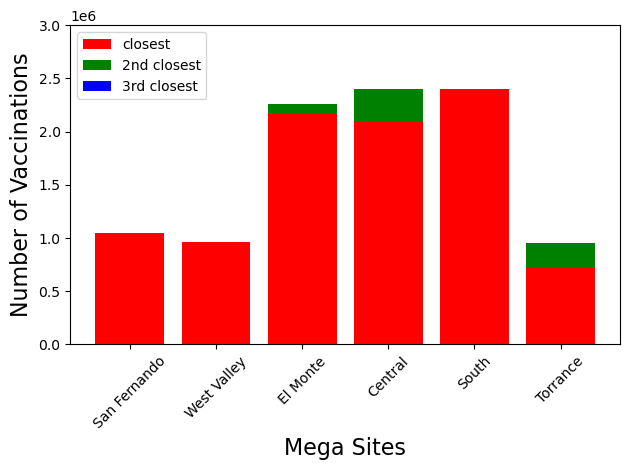

In [17]:
## plt.figure(figsize=(8, 6), dpi=300)  # Set figure size and DPI for high resolution


plt.bar(categories, values[0], color='red')
plt.bar(categories, values[1], bottom=values[0], color='green')
plt.bar(categories, values[2], bottom=values[1]+values[0], color='blue')


plt.xlabel('Mega Sites',fontsize=16)
plt.ylabel('Number of Vaccinations',fontsize=16)
#plt.title('Bar Plot Example')

plt.xticks(rotation=45)  # Rotate the x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.ylim(-1, 3000000)
plt.legend(['closest', '2nd closest', '3rd closest'])
plt.savefig('bar_plot.png', dpi=300, bbox_inches='tight')  # Save as a high-resolution image


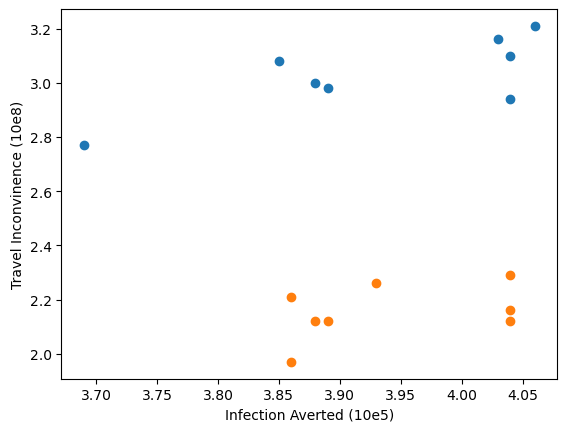

In [18]:
ia = np.array([3.69,3.86,4.03,3.93,4.06,4.04,4.04,4.04,3.89,3.88,4.04,4.04,3.88,3.89,3.85,3.86])
ti = np.array([2.77,1.97,3.16,2.26,3.21,2.29,2.94,2.12,2.98,2.12,3.1,2.16,3,2.12,3.08,2.21])
import matplotlib.pyplot as plt
ia1 = [ia[i] for i in range(0,len(ia),2)]
ia2 = [ia[i] for i in range(1,len(ia),2)]
ti1 = [ti[i] for i in range(0,len(ti),2)]
ti2 = [ti[i] for i in range(1,len(ti),2)]

plt.scatter(ia1, ti1)
plt.scatter(ia2, ti2)
plt.xlabel("Infection Averted (10e5)")
plt.ylabel("Travel Inconvinence (10e8)")
plt.show()

In [19]:
for i in range(0,len(ia),2):
    print(i)

0
2
4
6
8
10
12
14


In [20]:
((2.85-2.24)*10**8)/sum(total_pop)

6.083905636030444

In [21]:
((2.85-2.24)*(10**8))

60999999.999999985

In [22]:
target = emp*np.array(total_pop)
target

array([411672.60438144, 432458.63419201, 337910.09864348, 511913.16786287,
       855280.29965614, 332396.63939575, 408853.70356121, 302858.28331696,
       139171.47530335, 529919.17324923, 346254.03719972, 463094.04331544,
       281403.20229389, 645063.78480542, 273104.83672867, 191178.07071927,
       164292.05943687, 368731.470578  , 347391.97299079, 192247.15758764,
       395508.08725086, 314363.73239389, 199683.57420974, 403112.15784234,
       458460.58145268, 455079.977263  ])

In [23]:
groupedz = dfzrand.groupby(['t', 'i'])
resultsz = groupedz.sum()
groupedy = dfyrand.groupby(['t', 'i'])
resultsy = groupedy.sum()


/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_68151/3546390577.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultsz = groupedz.sum()
/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_68151/3546390577.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultsy = groupedy.sum()


In [24]:
score = 0
help_ = np.zeros(26)
for t in range(6):
    for i in range(26):
        help_[i] += (resultsz['value'][(t,i)]+resultsy['value'][(t,i)])
        score += max(0,target[i]-help_[i])
print(score)
print(ics)

24109655.59626855
196572213.4149999


In [25]:
16024558

16024558